# Building an Agentic Corrective RAG System with LangGraph

The idea would be to implement the workflow taking inspiration from the [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884) research paper.

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers


## Install OpenAI, and LangChain dependencies

Install the following httpx library version for compatibility with other libraries

In [1]:
!pip install httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [2]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-chroma==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain-core
    Fo

## Setup Environment Variables

In [1]:
from google.colab import userdata
import os

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Build a Search Index for Wikipedia Data

We will build a vector database for retrieval and search by taking a subset of documents from wikipedia, similar to our project from previous modules

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [2]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Get the wikipedia data

In [3]:
# if you can't download using the following code
# go to https://drive.google.com/file/d/1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW download it
# manually upload it on colab
!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

Downloading...
From (original): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW
From (redirected): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW&confirm=t&uuid=14884908-b945-4e0c-9a62-c835f8dddda2
To: /content/simplewiki-2020-11-01.jsonl.gz
100% 50.2M/50.2M [00:00<00:00, 116MB/s]


### Load and Chunk Documents

In [4]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = 'simplewiki-2020-11-01.jsonl.gz'

docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        #Add all paragraphs
        #passages.extend(data['paragraphs'])
        #Only add the first paragraph
        docs.append({
                        'metadata': {
                                        'title': data.get('title'),
                                        'article_id': data.get('id')
                        },
                        'data': ' '.join(data.get('paragraphs')[0:3]) # restrict data to first 3 paragraphs to run later modules faster
        })

# We subset our data so we only use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['india']
              if x in doc['data'].lower().split()]
# Create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]
# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [5]:
len(chunked_docs)

1322

In [6]:
chunked_docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [7]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_wikipedia_db',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./wikipedia_db")

### Setup a Vector Database Retriever

Here we use the following retrieval strategy:

- Similarity with Threshold Retrieval


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 3 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [8]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 3,
                                                                       "score_threshold": 0.3})

In [9]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '5114', 'title': 'Mumbai'}, page_content="Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million peo

In [10]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[]

## Create a Query Retrieval Grader

Here we will use an LLM itself to grade if any retrieved document is relevant to the given question - Answer will be either `yes` or `no`

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [12]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: binary_score='yes'

Mumbai (previously known as Bombay until 1996) is a natural harbor on the west coast of India, and is the capital city of Maharashtra state. It is India's largest city, and one of the world's most populous cities. It is the financial capital of India. The city is the second most-populous in the world. It has approximately 13 million people. Along with the neighboring cities of Navi Mumbai and Thane, it forms the world's 4th largest urban agglomeration. They have around 19.1 million people. The seven islands that form Bombay were home to fishing colonies. The islands were ruled by successive kingdoms and indigenous em

In [13]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

In [14]:
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

The 2023 ICC Cricket World Cup is scheduled to be hosted by India and India was selected as the host at an International Cricket Council (ICC) meeting in London in June 2013. This will be the 13th Cricket World Cup competition. It will be the fourth time that India will be the host. This will be the first time that India has hosted the tournament on its own. India hosted previous World Cup tournaments in 1987 (with Pakistan), 1996 (with Pakistan and Sri Lanka) and 2011 (with Sri Lanka and Bangladesh). The semi final will be played at Wankhede Stadium. And final will be played at Eden Gardens, Kolkata. 5. ICC Cricket Worldcup 2023 Venue
GRADE: binary_score='no'



## Build a QA RAG Chain

We will now connect our retriever to an LLM and build our QA RAG Chain

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [16]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

The capital of India is New Delhi. It is also a union territory and part of the larger megacity of Delhi.


In [17]:
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

I don't know the answer.


## Create a Query Rephraser

We will now build a query rephraser which will use an LLM to rephrase the input user query into a better version which is optimized for web search

In [18]:
# LLM for question rewriting
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)

question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [19]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'Who was the winner of the 2024 UEFA Champions League?'

## Load Web Search Tool

Here we will be using the [Tavily API](https://tavily.com/#api) for our web searches

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

## Build Agentic RAG components

Here we will build the key components of our Agentic Corrective RAG System as per the workflow below:

![](https://i.imgur.com/uhybMhT.png)



### Graph State

Used to store and represent the state of the agent graph as we traverse through various nodes

In [21]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB

This will be used to get relevant context documents from the vector database

In [22]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

### Grade documents

This will be used to determine whether the retrieved documents are relevant to the question by using an LLM Grader

Sets the `web_search_needed` flag as `Yes` if at least one document is not contextually relevant and sets it as `No` if all documents are contextually relevant to the given user query

In [23]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

### Rewrite query

This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

In [24]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web Search

This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [25]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Generate Answer

Standard LLM Response generation from query and context documents in a RAG system

In [26]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### Decide to Generate

This will be used as a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [27]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

### Build the Agent Graph

Here we will use LangGraph and build the agent as a graph

In [28]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

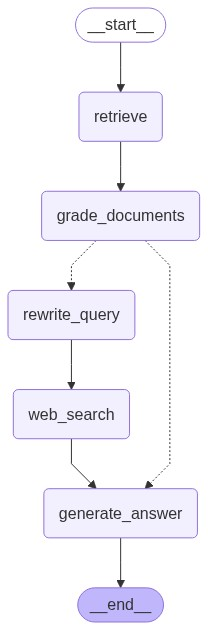

In [29]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

## Test the Agentic CRAG System

In [30]:
query = "what is the capital of India?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [31]:
display(Markdown(response['generation']))

The capital city of India is New Delhi. It is located in the north-central part of the country, to the west of the Yamuna River. New Delhi serves as the seat of the central government of India and is part of the National Capital Territory of Delhi.

In [32]:
response

{'question': 'What is the capital city of India?',
 'generation': 'The capital city of India is New Delhi. It is located in the north-central part of the country, to the west of the Yamuna River. New Delhi serves as the seat of the central government of India and is part of the National Capital Territory of Delhi.',
 'web_search_needed': 'Yes',
 'documents': [Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
  Document(page_content='The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.\n\nThe current capital city is New Delhi, which replaced Calcut

In [33]:
query = "who won the champions league in 2024?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [34]:
display(Markdown(response['generation']))

The winner of the 2024 UEFA Champions League was Real Madrid. They defeated Borussia Dortmund 2-0 in the final match held at Wembley Stadium in London, England, on June 1, 2024.

In [35]:
query = "Tell me about India"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [36]:
display(Markdown(response['generation']))

India is a country located in Asia, specifically at the center of South Asia. It is the seventh largest country in the world by area and the largest in South Asia. With a population exceeding 1.2 billion people, India is the second most populous country globally and holds the title of the most populous democracy in the world. The capital city of India is New Delhi.

Geographically, India is a peninsula, bordered by the Indian Ocean to the south, the Arabian Sea to the west, and the Bay of Bengal to the east. It shares its borders with seven countries: Pakistan to the northwest, China and Nepal to the north, Bhutan and Bangladesh to the northeast, Myanmar to the east, and Sri Lanka, an island nation, to the south.

India has a rich and diverse history that spans thousands of years, with its civilization beginning in the Indus Valley. The country has seen various languages, cultures, periods, and dynasties throughout its history. Archaeological evidence, such as stone tools and a skull, indicates the presence of early human species like "Homo erectus" in India between 200,000 and 500,000 years ago.

Economically, India is the fifth largest in the world with a GDP of $2.94 trillion. When considering purchasing power parity (PPP), it ranks as the third largest economy, valued at $10.51 trillion. Despite its large economy, the per capita income was relatively low at $6,209 (PPP) per person per year in 2015 due to its vast population. The Indian economy is diverse, encompassing agriculture, handicrafts, industries, and a significant service sector, which is the main driver of economic growth. The country has become a leader in information technology, partly due to its large pool of well-educated, English-speaking individuals.

Historically, India had strict government controls over various sectors, including telecommunications, banking, and foreign direct investment. However, since the early 1990s, under the leadership of P.V. Narasimha Rao and the economic reforms initiated by Manmohan Singh, India has gradually liberalized its markets, leading to rapid economic growth. Additionally, India has the third largest military force in the world and is recognized as a nuclear weapon state.